In [1]:
# Import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
import pickle

import warnings

warnings.simplefilter("ignore")

# Load saved data and models

In [2]:
# Load processed data
with open("X_train.pkl", "rb") as file:
    X_train = pickle.load(file)
    
with open("X_test.pkl", "rb") as file:
    X_test = pickle.load(file)    

with open("X.pkl", "rb") as file:
    X = pickle.load(file)      
    
with open("y_train.pkl", "rb") as file:
    y_train = pickle.load(file)        
    
with open("y_test.pkl", "rb") as file:
    y_test = pickle.load(file)   

with open("y.pkl", "rb") as file:
    y = pickle.load(file)      

In [4]:
# Drop chronic_disease_binary, which is pretty useless
X_train.drop(["chronic_disease_binary"], axis=1, inplace=True)
X_test.drop(["chronic_disease_binary"], axis=1, inplace=True)
X.drop(["chronic_disease_binary"], axis=1, inplace=True)

# Preprocessing

In [5]:
# Same feature names
feature_names = X.columns.tolist()

In [6]:
# Impute missing values
imp_train = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_test = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_full = SimpleImputer(missing_values=np.nan, strategy='mean')

X_train = imp_train.fit_transform(X_train)
X_test = imp_test.fit_transform(X_test)
X = imp_full.fit_transform(X)

In [7]:
# Oversample
res_train = SMOTE()
X_train, y_train = res_train.fit_resample(X_train, y_train)

res_test = SMOTE()
X_test, y_test = res_test.fit_resample(X_test, y_test)

res_full = SMOTE()
X, y = res_full.fit_resample(X, y)

In [8]:
# Convert back to dataframes (or scaler somehow doesn't work)
X_train = pd.DataFrame(X_train, columns = feature_names)
X_test = pd.DataFrame(X_test, columns = feature_names)
X = pd.DataFrame(X, columns = feature_names)

In [9]:
# Scale age
scale_full = RobustScaler()
scale_train = RobustScaler()
scale_test = RobustScaler()

X_train["age"] = scale_train.fit_transform(X_train[["age"]])
X_test["age"] = scale_test.fit_transform(X_test[["age"]])
X["age"] = scale_full.fit_transform(X[["age"]])

# Model training

AUC in each fold: [0.86457546 0.90854119 0.92302847 0.91710758 0.91635173 0.92239859
 0.91962711 0.89795918 0.91484001 0.95439657]; mean: 0.9138825900730663

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       159
           1       0.93      0.93      0.93       159

    accuracy                           0.93       318
   macro avg       0.93      0.93      0.93       318
weighted avg       0.93      0.93      0.93       318



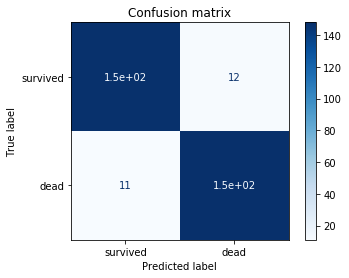

In [10]:
# SVM classifier object
clf = svm.SVC(probability=True)

# Train classifier and evaluate performance
def model_fit(model, data_train, data_test, target_train, target_test):

    # Fit on training data
    model.fit(data_train, target_train)

    # Cross validate on training data
    scores = cross_val_score(model, data_train, target_train, cv=10, scoring="roc_auc")
    print("AUC in each fold: {}; mean: {}\n".format(scores, scores.mean()))

    # Predict outcome for testing data
    y_pred = model.predict(data_test)

    # Display performance metrics
    svm_eval = classification_report(target_test, y_pred, labels=[0, 1])
    print(svm_eval)

    # Confusion matrix
    plot_confusion_matrix(
        model,
        data_test,
        target_test,
        display_labels=["survived", "dead"],
        cmap=plt.cm.Blues,
        normalize=None,
    )
    plt.title("Confusion matrix")
    
model_fit(clf, X_train, X_test, y_train, y_test)    

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       789
           1       0.90      0.85      0.87       789

    accuracy                           0.88      1578
   macro avg       0.88      0.88      0.88      1578
weighted avg       0.88      0.88      0.88      1578



Text(0.5, 1.0, 'Confusion matrix')

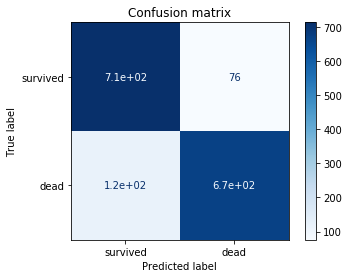

In [11]:
# Retrain on full data
clf.fit(X, y)

# Cross validation
y_pred = clf.predict(X)
svm_eval = classification_report(y, y_pred, labels=[0, 1])
print(svm_eval)

# Confusion matrix
plot_confusion_matrix(
    clf,
    X,
    y,
    display_labels=["survived", "dead"],
    cmap=plt.cm.Blues,
    normalize=None,
)
plt.title("Confusion matrix")

# Predict your risk

## Try for yourself

In [12]:
# Function: Take patient info
def patient_info():

    # Demographic info
    age = input("What's your age?")
    sex = input("What's your biological sex? (female: 1, male: 0)")
#     country = input("Which country do you live in?")
#     docs_per_10k = medical.loc[
#         medical["country"].str.contains(country), "docs_per_10k"
#     ].item()
#     beds_per_10k = medical.loc[
#         medical["country"].str.contains(country), "beds_per_10k"
#     ].item()

    # Pre-conditions
#     preconition = input("Any chronic dieases that you know of? (yes: 1, no: 0)")
    hypertension = input("Do you have hypertension? (yes: 1, no: 0)")
    diabetes = input("Do you have diabetes? (yes: 1, no: 0)")
    heart = input("Do you have heart diseases? (yes: 1, no: 0)")

    # Symptoms
    fever = input("Do you have fever? (yes: 1, no: 0)")
    cough = input("Are you coughing? (yes: 1, no: 0)")
    fatigue = input("Do you feel fatigue? (yes: 1, no: 0)")
    sore_throat = input("Do you have a sore throat? (yes: 1 , no:0)")

    # Save results in a list
    return {
        "age_scaled": float(scale_full.transform([[age]])),
        "sex": int(sex),
#         "chronic_disease_binary": int(preconition),
#         "beds_per_10k": float(beds_scaler.transform([[beds_per_10k]])),
#         "docs_per_10k": float(docs_scaler.transform([[docs_per_10k]])),
        "hypertension": int(hypertension),
        "diabetes": int(diabetes),
        "heart": int(heart),
        "fever": int(fever),
        "cough": int(cough),
        "fatigue": int(fatigue),
        "sore throat": int(sore_throat),
    }

# Function: Output risk
def risk_predictor():

    # Get patient info
    new_case = patient_info()

    # Convert to useable format
    new_case = pd.DataFrame(new_case, index=[0])

    # Make prediction
    new_prediction = clf.predict_proba(new_case)

    # Print result
    print(
        "Once contracted COVID-19, your mortality risk is {}%.".format(
            round(new_prediction[0][1] * 100, 2)
        )
    )

In [13]:
risk_predictor()

What's your age? 25
What's your biological sex? (female: 1, male: 0) 0
Do you have hypertension? (yes: 1, no: 0) 0
Do you have diabetes? (yes: 1, no: 0) 0
Do you have heart diseases? (yes: 1, no: 0) 0
Do you have fever? (yes: 1, no: 0) 0
Are you coughing? (yes: 1, no: 0) 0
Do you feel fatigue? (yes: 1, no: 0) 0
Do you have a sore throat? (yes: 1 , no:0) 0


Once contracted COVID-19, your mortality risk is 11.86%.


## Save model

In [14]:
with open("covid19_risk_svm.pkl", "wb") as file:
    pickle.dump(clf, file, protocol = 2)

In [15]:
with open("svm_scaler.pkl", "wb") as file:
    pickle.dump(scale_full, file, protocol = 2)